In [2]:
import torch
from torchvision import datasets as dts
from torchvision.transforms import ToTensor 
import matplotlib.pyplot as plt
import torch.nn.functional as F
%matplotlib inline


In [106]:
traindt_m = dts.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
testdt_m = dts.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor(),
    download = True
)
testdt = torch.utils.data.DataLoader(testdt_m, shuffle=True, batch_size=128)
traindt = torch.utils.data.DataLoader(traindt_m, shuffle=True, batch_size=128)
examples = enumerate(testdt)
batch_idx, (example_data, example_targets) = next(examples)


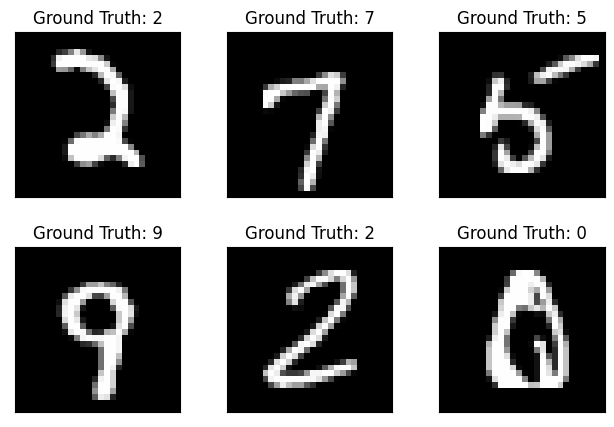

In [68]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])


In [110]:
class Linear:
  def __init__(self, fan_in, fan_out, bias = True) -> None:
    self.weights = torch.randn((fan_in, fan_out)) / fan_in**0.5 * 0.1
    self.bias = torch.zeros((1, fan_out)) if bias else None

  def __call__(self, x):
    self.out = x @ self.weights
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weights] + ( [self.bias] if self.bias is not None else [])

class Tanh:    
  def __call__(self, x) -> None:
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

class BatchNorm1d:
  def __init__(self, dim , eps = 1e-5 ,momentum = 0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True

    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    

    if self.training:
      xmean = x.mean(0, keepdim = True)
      xvar = x.var(0, keepdim = True)

    else:
      xmean = self.running_mean
      xvar = self.running_var
    
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
    out = xhat * self.gamma + self.beta
    
    
    if self.training:
      with torch.no_grad():
        self.running_mean = self.running_mean * (1-self.momentum) + xmean*self.momentum
        self.running_var = self.running_var * (1-self.momentum) + xvar*self.momentum

    return out
    
  def parameters(self):
    return [self.gamma, self.beta]

class Sequential:
  def __init__(self, layers):
    self.layers = layers

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

class Flatten:
  def __init__(self, dim):
    self.dim = dim
  
  def __call__(self, x):
    return x.view(x.shape[0] , self.dim[0]*self.dim[1])

  def parameters(self):
    return []


In [10]:
i = 0
a = Flatten((28,28))
for batch in enumerate(testdt):
    if i == 1:
        break
    print(len(batch))

    batch_idx, (data, data_targets) = batch
    pixels = data.squeeze(1)
    flat = a(pixels)
    print(flat.shape)
    i += 1


2
torch.Size([10, 784])


In [111]:
##### Image Info #####
img_dim = (28,28)

##### Neural Network Initialization ######
model = Sequential([Flatten(img_dim),
Linear(img_dim[0] * img_dim[1], 3000),
Linear(3000, 3000), BatchNorm1d(3000), Tanh(),
Linear(3000, 200), BatchNorm1d(200), Tanh(),
Linear(200, 10)])

for p in model.parameters():
    p.requires_grad = True


#### Stats Tracking ###
loss_i = []

In [117]:
##### Training #####
it = 1
batch_len = 128

for i in range(it):
    traindt = torch.utils.data.DataLoader(traindt_m, shuffle=True, batch_size=batch_len)
    for i, batch in enumerate(traindt):

        x, y = batch
        logits = model(x)
        loss = F.cross_entropy(logits, y)
        print(f"Iteration {i}: {loss.item()}")
        loss.backward()

        loss_i.append(loss.item())

        learning_rate = 0.000001
        for parameter in model.parameters():
            parameter.data += -learning_rate * parameter.grad


Iteration 0: 0.37339621782302856
Iteration 1: 0.24332813918590546
Iteration 2: 0.28465238213539124
Iteration 3: 0.1285068690776825
Iteration 4: 0.25782886147499084
Iteration 5: 0.17809489369392395
Iteration 6: 0.2505432963371277
Iteration 7: 0.2292862832546234
Iteration 8: 0.22240452468395233
Iteration 9: 0.23433375358581543
Iteration 10: 0.3978757858276367
Iteration 11: 0.1782316267490387
Iteration 12: 0.3828809857368469
Iteration 13: 0.22002267837524414
Iteration 14: 0.16407622396945953
Iteration 15: 0.3611631989479065
Iteration 16: 0.18050332367420197
Iteration 17: 0.31937339901924133
Iteration 18: 0.15244843065738678
Iteration 19: 0.17883314192295074
Iteration 20: 0.2766522765159607
Iteration 21: 0.2550089359283447
Iteration 22: 0.2089541107416153
Iteration 23: 0.2672853171825409
Iteration 24: 0.263069212436676
Iteration 25: 0.37625232338905334
Iteration 26: 0.24480366706848145
Iteration 27: 0.2957146465778351
Iteration 28: 0.3274996280670166
Iteration 29: 0.15273664891719818
Itera

KeyboardInterrupt: 

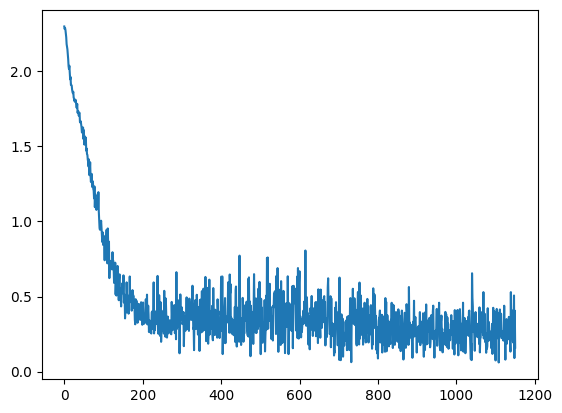

In [118]:
plt.plot(loss_i)

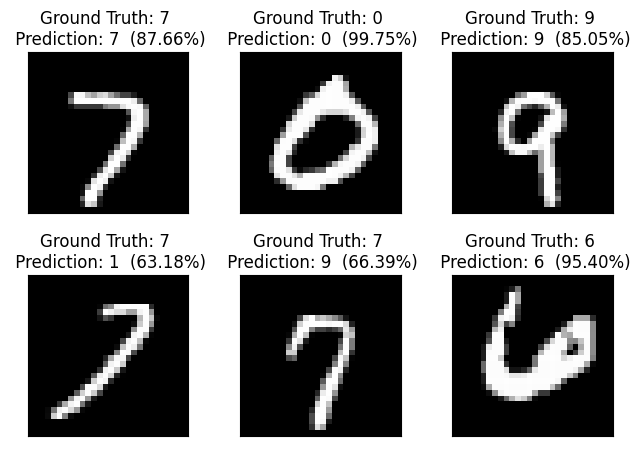

In [135]:
############ Select and predict one image  ###########
testdt = torch.utils.data.DataLoader(testdt_m, shuffle=True, batch_size=6)

(data_pixels, data_truth) = next(iter(testdt))

### Prediction ###

logits = model(data_pixels)
probs = F.softmax(logits, dim=1)
data_pred_prob, data_pred = probs.max(dim=1)


### Display ###
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(data_pixels[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {} \n Prediction: {}  ({:.2f}%)".format(data_truth[i], data_pred[i], data_pred_prob[i].item() * 100))
  plt.xticks([])
  plt.yticks([])

In [149]:
testdt = torch.utils.data.DataLoader(traindt_m, shuffle=True, batch_size=10000)

total_count = 0
correct_count = 0
error_count = 0

data_pixels, data_truth = next(iter(testdt))

### Prediction ###
logits = model(data_pixels)
probs = F.softmax(logits, dim=1)
data_pred_prob, data_pred = probs.max(dim=1)

### Stats ###

for i, pred in enumerate(data_pred):

    total_count += 1
    if pred == data_truth[i]:
        correct_count += 1
    else:
        error_count += 1
print(f"Accuracy: {correct_count/total_count * 100 :.2f} %")


Accuracy: 93.35 %
